# Rekognition demo

First we import the modules we will need

![title](Rekognition.png)

In [74]:
import boto3
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import io
import IPython
from IPython.display import display
from IPython.display import JSON
import urllib.request

### Fetch image given a url
This is a function, which given an image url will fetch the image and return the image as a stream of bytes.
Another approach is to provide the S3 bucket and key where the image is located, but for the demo purposes we grab the image as bytes.

In [75]:
def getImageAsBytes(imageurl):
    imagedata = urllib.request.urlopen(imageurl).read()
    return imagedata 


### Rekognition label detection (***)
This function is where we invoke Rekognition to do the label detection
For more details see the API reference here: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_labels

![title](Rekognition-object-and-scene-detection.png)

In [76]:
def getLabels(imageurl):
    imageasbytes = getImageAsBytes(imageurl)
    
    client = boto3.client('rekognition')
    response = client.detect_labels(
        Image={'Bytes': imageasbytes},
        MaxLabels=100,
        MinConfidence=0.5
    )
    JSON(response)
    return response["Labels"]

### draw bounding boxes for labels

This is a function that we use to draw the bounding boxes given the labels detected by Rekognition. This is for visualization purposes.

In [77]:
def makeBoundingBoxes(image, labels, maxboxes=10):
    #image = Image(imageData)
    draw = ImageDraw.Draw(image) 
    imgWidth, imgHeight = image.size  
    for labelDetail in labels:
        #print(labelDetail)
        
        labelname = labelDetail["Name"]
        labelconfidence = labelDetail["Confidence"]
        
        for instance in labelDetail["Instances"]:    
            box = instance['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']
                
            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top)

            )
            draw.line(points, fill='#00d400', width=2)  
            fnt = ImageFont.load_default().font  
            draw.text((left , top), labelname, font = fnt, align ="left", fill='#00d400')            
    #display(image)
    return image


### Fetch the image and display

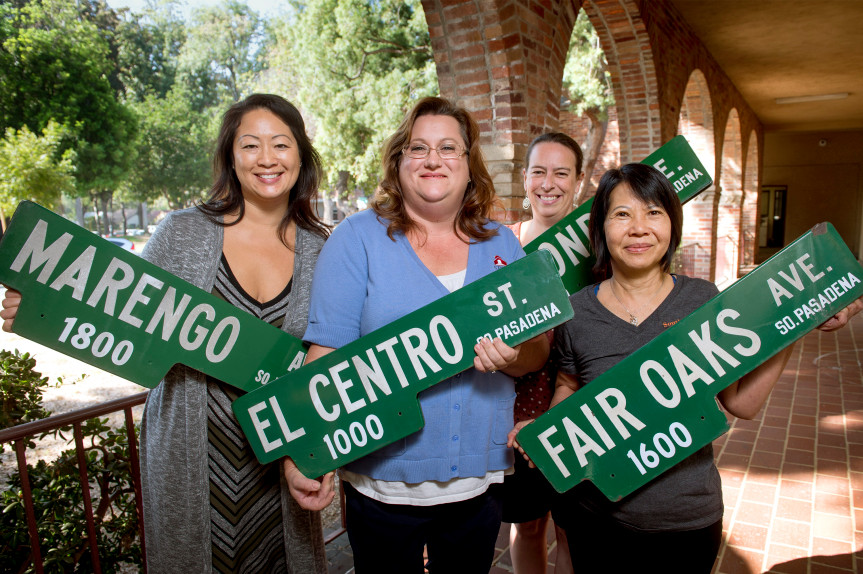

In [78]:
imageurl = "https://www.pasadenastarnews.com/wp-content/uploads/2017/10/pas-l-signsale-1014.jpg?w=863"
mydata = getImageAsBytes(imageurl)
display(IPython.display.Image(data=mydata))
stream = io.BytesIO(mydata)
img = Image.open(stream)

### Call the get_labels method of Rekognition

Given a url, we invoke Rekognition to give us the labels. We also print out the labels returned as a JSON object.

In [79]:
#labels = getLabels("https://raw.githubusercontent.com/dupled3031/AWS-AIML-examples/master/data/images/13.jpg")
labels = getLabels(imageurl)
JSON(labels)



<IPython.core.display.JSON object>

### create a new image with the bounding boxes

In [80]:
newimage = makeBoundingBoxes(img, labels, maxboxes=10)



### Display the image

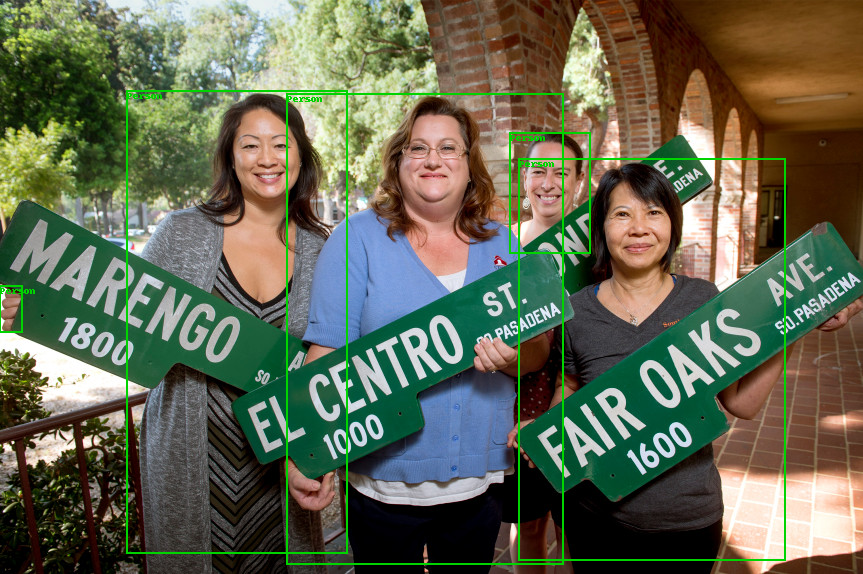

In [81]:
display(newimage)

### Another bounding boxes function

In [82]:
def makeFaceBoundingBoxes(image, labels, maxboxes=10):
    #image = Image(imageData)
    draw = ImageDraw.Draw(image) 
    imgWidth, imgHeight = image.size  
    for labelDetail in labels:
        #print(labelDetail)
         
        box = labelDetail['BoundingBox']
        left = imgWidth * box['Left']
        top = imgHeight * box['Top']
        width = imgWidth * box['Width']
        height = imgHeight * box['Height']

        points = (
            (left,top),
            (left + width, top),
            (left + width, top + height),
            (left , top + height),
            (left, top)

        )
        fnt = ImageFont.load_default().font
        draw.line(points, fill='#fc0320', width=2)  
        draw.text((left , top), "face", font = fnt, align ="left", fill='#fc0320') 
    return image

# This is how we invoke the GetFaces method (***)
We can either pass the image as bytes or we can pass the S3 bucket and key. In this example we get the image as bytes
https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_faces

![title](Rekognition-face-analysis.png)

In [83]:
def getFaces(imageurl):
    imageasbytes = getImageAsBytes(imageurl)
    
    client = boto3.client('rekognition')
    response = client.detect_faces(
        Image={'Bytes': imageasbytes},
        Attributes = ['ALL']
    )
    JSON(response)
    return response["FaceDetails"]

### This is where we invoke the function
You can see the output we get back from Rekognition

In [84]:
imageurl= "https://www.pasadenastarnews.com/wp-content/uploads/2017/10/pas-l-signsale-1014.jpg?w=863"
faces = getFaces(imageurl)
JSON(faces)

<IPython.core.display.JSON object>

### we make bounding boxes and display the image

In [85]:
newimage = makeFaceBoundingBoxes(newimage, faces, maxboxes=10)

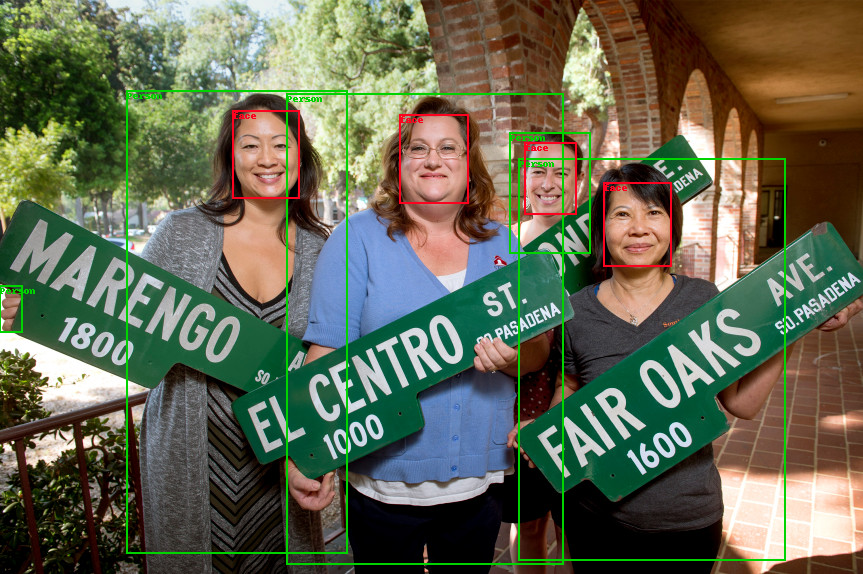

In [86]:
display(newimage)

In [87]:
def makeTextBoundingBoxes(image, blocks, maxboxes=10):
    #image = Image(imageData)
    draw = ImageDraw.Draw(image) 
    imgWidth, imgHeight = image.size  
    for block in blocks:
        labelname = block.get("DetectedText", block["Type"])
        box = block['Geometry']['BoundingBox']
        left = imgWidth * box['Left']
        top = imgHeight * box['Top']
        width = imgWidth * box['Width']
        height = imgHeight * box['Height']

        points = (
            (left,top),
            (left + width, top),
            (left + width, top + height),
            (left , top + height),
            (left, top)

        )
        draw.line(points, fill='#fc03be', width=2)  
        fnt = ImageFont.load_default().font  
        draw.text((left , top), labelname, font = fnt, align ="left", fill='#fc03be')            
    #display(image)
    return image

The code below invokes Rekognition to detect text from image. 
https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_text 

In [88]:
def getText(imageurl):
    imageasbytes = getImageAsBytes(imageurl)
    
    client = boto3.client('rekognition')
    response = client.detect_text(
        Image={'Bytes': imageasbytes},
    )
    #print(response)
    return response["TextDetections"]

In [89]:
textDetected = getText(imageurl)
JSON(textDetected)

<IPython.core.display.JSON object>

In [90]:
newimage = makeTextBoundingBoxes(newimage, textDetected, maxboxes=10)

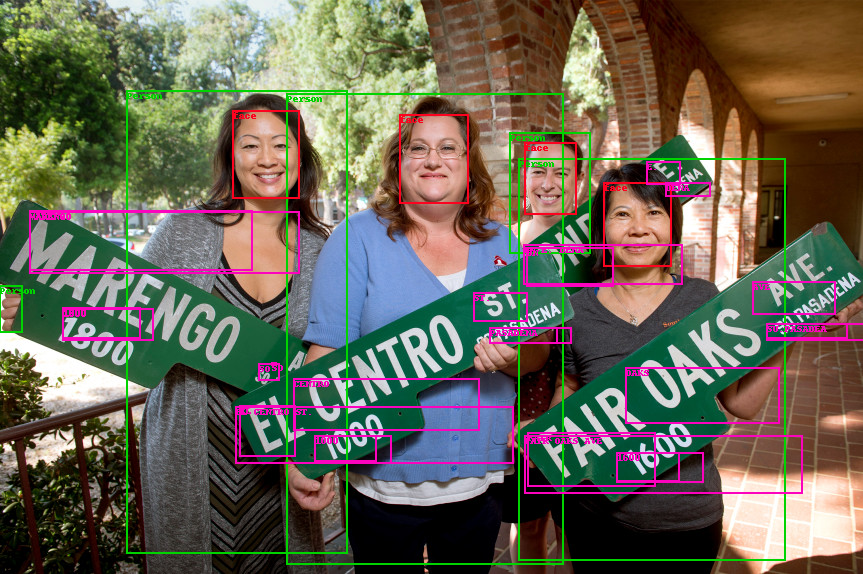

In [91]:
display(newimage)

# Reference architecture

![title](Rekognition-reference-arch.png)